# Com S 574 - HW 2
## Miles Lucas

## Problem 2 - Linear Regression

What linear model would be a sutiable choice for modeling the following data

In [1]:
# Imports and Setup
library(ggplot2)
library(gridExtra)
library(lmtest)
library(lawstat)
# Set theme
theme_set(theme_bw())

Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: Kendall
Loading required package: mvtnorm
Loading required package: VGAM
Loading required package: stats4
Loading required package: splines

Attaching package: ‘VGAM’

The following object is masked from ‘package:lmtest’:

    lrtest



In [2]:
filename <- "./data/HW2Q2.dat"
data <- read.table(filename, sep=' ', header=TRUE)

Let's start by plotting the raw data.

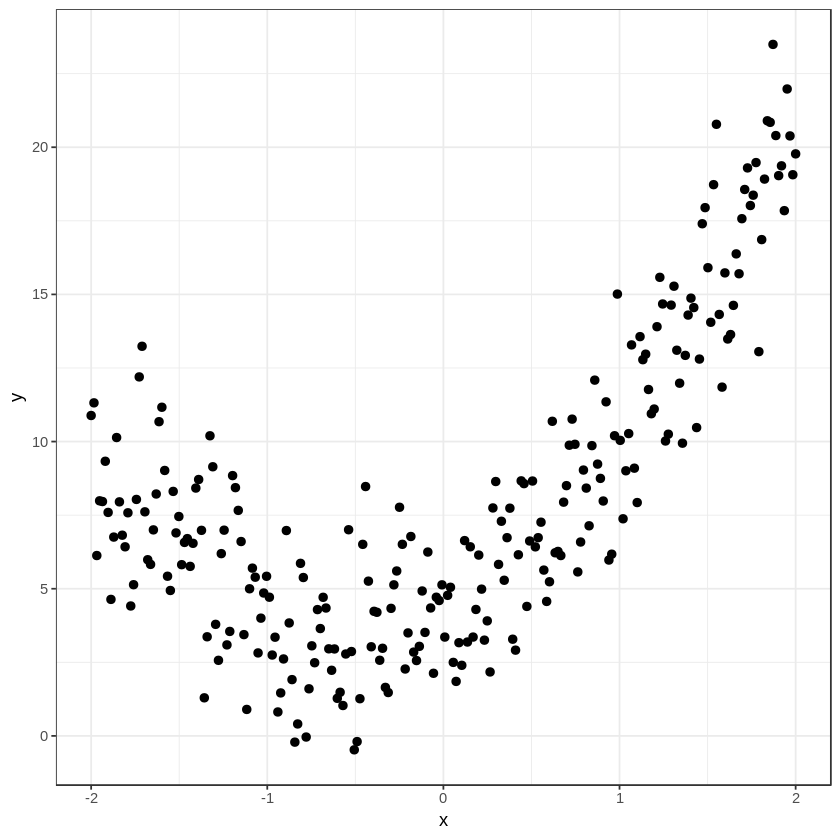

In [3]:
ggplot(data, aes(x=x, y=y)) + geom_point(cex=2)

The first thing I notice is that the data does not look linear. Looks are not the whole story though, so I will proceed doing the appropriate tests for my report.

### Doing the regression

#### Baby's First Model

\begin{equation}
    Y = \beta_0 + \beta_1 X + e_i
\end{equation}

Note that I am suppressing the output because I need to make some simple checks to see if doing OLS is even appropriate

In [4]:
ols = lm(y~1+x, data)

 ---
 Let's see what this looks like

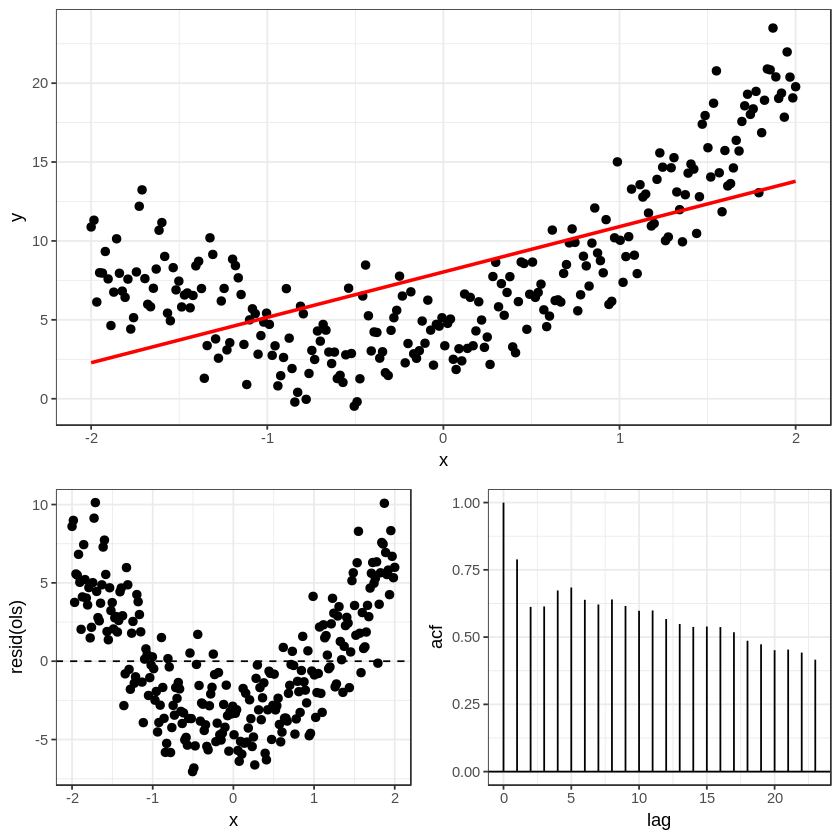

In [5]:
p1 <- ggplot(data, aes(x=x, y=y)) + geom_point(cex=2) + geom_line(aes(x=x, y=ols$fitted.values), cex=1, color=2)
p2 <- ggplot(data, aes(x=x, y=resid(ols))) + geom_point(cex=2) + geom_hline(yintercept=0, linetype='dashed')
bacf <- acf(resid(ols), plot = FALSE)
bacfdf <- with(bacf, data.frame(lag, acf))
p3 <- ggplot(data = bacfdf, mapping = aes(x = lag, y = acf)) +
       geom_hline(aes(yintercept = 0)) +
       geom_segment(mapping = aes(xend = lag, yend = 0))
grid.arrange(p1, p2, p3, heights=c(2, 1.5), layout_matrix=matrix(c(1, 2, 1, 3), 2, 2))

### Testing our initial assumptions

In order to perform ordinary least squares, I need to prove these assumptions are valid:

1. $\mathbb{E}(e_i)=0$
2. $\mathbb{V}(e_i)=\sigma^2_e$ (errors are constant, or homoscedastic)
3. $\text{cov}(e_i, e_j)=0 \quad \forall i\neq j$ (errors are uncorrelated)

I assert these assumptions by performing the following tests with significance level $\alpha$=0.05:

#### Run's Test

This will test if our errors are homoscedastic. I take a null hypothesis that the errors are homoscedastic with an alternative hypothesis that the errors are not homoscedastic. I call the `runs.test` from R, which works fine in Julia because Julia is a great programming language

In [6]:
runs.test(resid(ols))


	Runs Test - Two sided

data:  resid(ols)
Standardized Runs Statistic = -10.013, p-value < 2.2e-16


Uh oh. The output of the runs test out my significance level means we reject the null-hypothesis. This implies that our errors are not random and we cannot trust our ordinary least-squares fit.

#### Baby's Second Model

I want to see what possible polynomial fits work with the data. I will test polynomials from orders 2-5 where
\begin{equation}
    y_n(x_i) = \beta_0 + \beta_1 x_i + \beta_2 x_i^2 + ... + \beta_n x^n + e_i = \sum_k^n {\beta_k x_i^k} + e_i
\end{equation}

In [7]:
models = list(
    lm(y~poly(x, 2), data=data),
    lm(y~poly(x, 3), data=data),
    lm(y~poly(x, 4), data=data),
    lm(y~poly(x, 5), data=data)
)

Lets see the output of Run's test:

In [8]:
indices = seq_along(models)
for (ind in indices) {
    t <- runs.test(resid(models[[ind]]))
    message(sprintf("Runs Test - Two sided. Polynomial order: %d. p-value= %f", ind, t$p.value))
}

Runs Test - Two sided. Polynomial order: 1. p-value= 0.000387
Runs Test - Two sided. Polynomial order: 2. p-value= 0.000387
Runs Test - Two sided. Polynomial order: 3. p-value= 0.000143
Runs Test - Two sided. Polynomial order: 4. p-value= 0.000387


It looks like none of these models change the correlation of the errors. This violates all of our simple linear regression assumptions. Therefore **I cannot reasonable recommend any of these models**.

----

Below I show a plot of all the orders and their residuals for visual inspection.

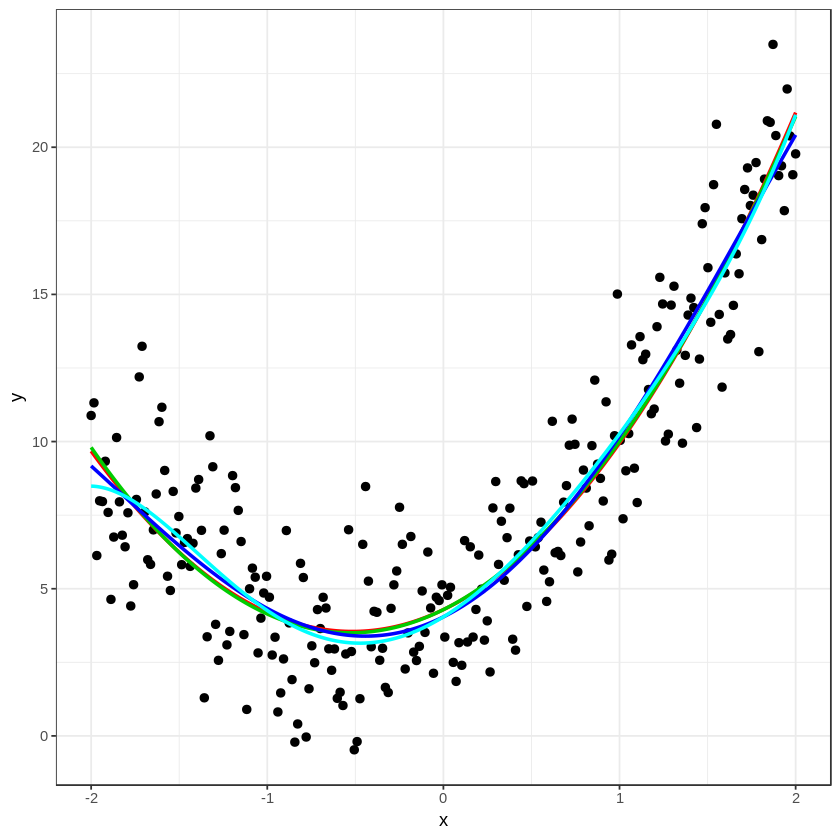

In [9]:
lines <- ggplot(data, aes(x=x, y=y)) + geom_point(cex=2)
# p2 <- ggplot(data) + geom_hline(yintercept=0, linetype='dashed')
for (ind in indices) {
    lines <- lines + geom_line(aes_string(x=data$x, y=models[[ind]]$fitted.values), 
                               cex=1, color=1+ind)
}
lines

### Final Model

Unfortunately, I cannot wholeheartadly recommend any of these models as a statistician. I will happily show the best looking model, but please note: **just because a model looks good does not mean it is good**. All of the polynomial fits are just about the same, so I will present the simples one. Its coefficients are:

In [10]:
models[[1]]$coefficients

(Intercept) poly(x, 2)1 poly(x, 2)2 
   8.032129   52.706141   52.913292

and here is a full plot-

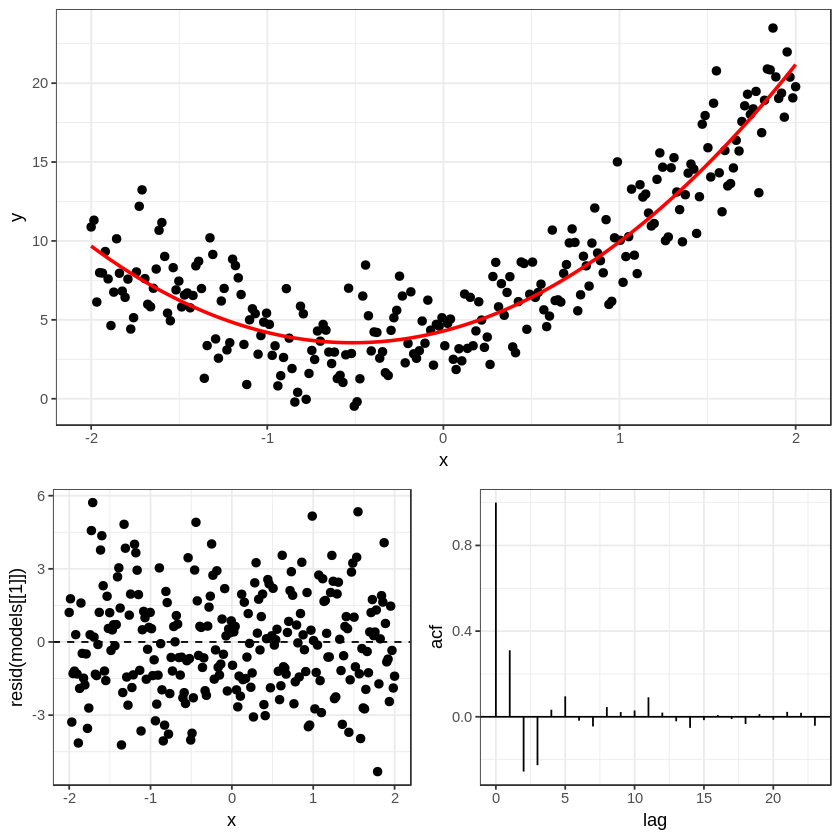

In [11]:
p1 <- ggplot(data, aes(x=x, y=y)) + geom_point(cex=2) + geom_line(aes(x=x, y=models[[1]]$fitted.values), cex=1, color=2)
p2 <- ggplot(data, aes(x=x, y=resid(models[[1]]))) + geom_point(cex=2) + geom_hline(yintercept=0, linetype='dashed')
bacf <- acf(resid(models[[1]]), plot = FALSE)
bacfdf <- with(bacf, data.frame(lag, acf))
p3 <- ggplot(data = bacfdf, mapping = aes(x = lag, y = acf)) +
       geom_hline(aes(yintercept = 0)) +
       geom_segment(mapping = aes(xend = lag, yend = 0))
grid.arrange(p1, p2, p3, heights=c(2, 1.5), layout_matrix=matrix(c(1, 2, 1, 3), 2, 2))